# Trabalho 2 de TAG
## Grupo
- Lucas Mendes De Albuquerque Barreto Fonseca (241020750)
- Artur Nunes de Souza (241002485)

## Passos
1. Ler dados do arquivo `entradaProj2.25TAG.txt`
2. Emparelhar projetos com alunos, com as seguintes regras:
    - **Preferência de projetos**:
        ordenada por nota do aluno (decrescente). Em caso de empate de nota,
        desempata-se pela parte numérica da matrícula (menor primeiro)
    - **Preferência de aluno**:
       cada aluno tem uma lista de preferência, referente aos projetos. Para participar de
      um projeto, esse projeto deve estar nessa lista
    - **Limite de vagas**: 
        Cada projeto aceita até `vagas-max`alunos por iteração
    - **Requisitos mínimos**:
        cada projeto define um `requisito-min` (fixado em 1 nesta versão),
        que representa a quantidade de alunos necessários para o projeto ser feito,
        e ter um *status* de atendido

3. Mostrar visualmente cada iteração do algoritmo de emparelhemento em um grafo
4. Gerar tabelas com informações de emparelhamentos
   

## 0. Imports e setup

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import re

# --- CONFIGURAÇÃO ---
NOME_ARQUIVO_ENTRADA = 'entradaProj2.25TAG.txt'

## 1. Estruturas de dados utilizados

In [2]:
class Projeto:
    """
    Representa um Projeto.
    Define requisito_min de alunos fixo em 1 (conforme especificação).
    """
    def __init__(self, codigo, vagas_max, req_min_nota):
        self.codigo = codigo
        self.vagas_max = vagas_max
        self.requisito_min = 1      # Requisito MÍNIMO de alunos (Obrigatório 1) 
        self.req_min_nota = req_min_nota # Requisito MÍNIMO de nota do aluno (3, 4, 5)
        self.candidatos = []      
        self.emparelhados = []    
        self.rank_preferencia = {}

class Aluno:
    """Representa um Aluno."""
    def __init__(self, matricula, nota, preferencias):
        self.matricula = matricula
        self.nota = nota          
        self.preferencias = preferencias 
        self.propostas_feitas = [] 
        self.emparelhado = None   
        self.rank_projeto_escolhido = None

## 2. Função de leitura e parse dos dados no arquivo

In [3]:
def ler_dados_do_arquivo(file_path, alunos, projetos):
    """Lê o arquivo de entrada, valida a nota e constrói as listas iniciais de candidatos."""
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            data_string = f.read()
    except FileNotFoundError:
        print(f"ERRO FATAL: Arquivo '{file_path}' não encontrado.")
        return False
        
    lines = [line.strip() for line in data_string.split('\n') if line.strip() and not line.startswith('//')]
    
    PROJETO_PATTERN = re.compile(r'\((\w+),\s*(\d+),\s*(\d+)\)')
    ALUNO_PATTERN = re.compile(r'\((\w+)\):\(([^)]*)\)\s*\((\d)\)')
    
    is_project_section = True
    for line in lines:
        if is_project_section:
            match = PROJETO_PATTERN.match(line)
            if match:
                codigo, vagas_max_str, req_min_nota_str = match.groups()
                projetos[codigo] = Projeto(codigo, int(vagas_max_str), int(req_min_nota_str))
            
            if ALUNO_PATTERN.match(line):
                is_project_section = False
        else:
            match = ALUNO_PATTERN.match(line)
            if match:
                matricula, prefs_str, nota_str = match.groups()
                prefs = [p.strip() for p in prefs_str.split(',') if p.strip()]
                alunos[matricula] = Aluno(matricula, int(nota_str), prefs)
    
    for aluno_obj in alunos.values():
        for cod_projeto in aluno_obj.preferencias:
            projeto = projetos.get(cod_projeto)
            if projeto and aluno_obj.nota >= projeto.req_min_nota:
                projetos[cod_projeto].candidatos.append(aluno_obj.matricula)
                
    print(f"Dados processados: {len(projetos)} projetos, {len(alunos)} alunos.")
    return True

## 3. Função de construção das listas de preferências dos projetos

In [4]:
def construir_rank_projetos(alunos, projetos):
    """
    Constrói a lista de preferência dos projetos.
    Critério: Nota (Decrescente) > Matrícula (Ascendente, como desempate).
    """
    for projeto in projetos.values():
        lista_alunos = [alunos[mat] for mat in projeto.candidatos if mat in alunos]
        
        # Seleção impessoal e competitiva: Nota mais alta primeiro
        lista_alunos.sort(key=lambda a: (a.nota, -int(a.matricula[1:])), reverse=True)
        
        projeto.candidatos = []
        for rank, aluno in enumerate(lista_alunos, 1):
            projeto.rank_preferencia[aluno.matricula] = rank
            projeto.candidatos.append(aluno.matricula)


## 4. Lógica principal de emparelhamento, Gale-Shapley modificado

In [5]:
def emparelhamento_spa(alunos, projetos, max_iteracoes=10):
    """Executa o algoritmo de Emparelhamento Aluno-Projeto (SPA)."""
    alunos_nao_emparelhados = list(alunos.values())
    historico_iteracoes = [] 

    print("\nIniciando Algoritmo de Emparelhamento Estável (Aluno Proponente)...")
    
    for iteracao in range(1, max_iteracoes + 1):
        propostas_ativas = defaultdict(list)
        proponentes_atual = False
        
        # Fase 1: Propostas dos Alunos
        for aluno in alunos_nao_emparelhados:
            for cod_projeto in aluno.preferencias:
                if cod_projeto not in aluno.propostas_feitas:
                    projeto = projetos.get(cod_projeto)
                    
                    if projeto and aluno.nota >= projeto.req_min_nota:
                        propostas_ativas[cod_projeto].append(aluno.matricula)
                        aluno.propostas_feitas.append(cod_projeto)
                        proponentes_atual = True
                        break 
                    else:
                        aluno.propostas_feitas.append(cod_projeto)
        
        if not proponentes_atual:
            print(f"\nEmparelhamento finalizado na iteração {iteracao-1} (estável/nenhuma nova proposta).")
            break

        emparelhamento_temp = defaultdict(list)
        rejeicoes_temp = defaultdict(list)
        
        # Fase 2: Respostas dos Projetos
        for cod_projeto, lista_alunos_prop in propostas_ativas.items():
            projeto = projetos[cod_projeto]
            alunos_candidatos = lista_alunos_prop + projeto.emparelhados
            alunos_candidatos.sort(key=lambda mat: projeto.rank_preferencia.get(mat, float('inf'))) 
            
            alunos_aceitos = alunos_candidatos[:projeto.vagas_max]
            alunos_rejeitados = [mat for mat in alunos_candidatos[projeto.vagas_max:] if mat in alunos_candidatos]
            
            projeto.emparelhados = alunos_aceitos
            emparelhamento_temp[cod_projeto] = alunos_aceitos
            rejeicoes_temp[cod_projeto] = alunos_rejeitados

        # Fase 3: Atualização dos Alunos Rejeitados
        alunos_rejeitados_mats = set(mat for mats in rejeicoes_temp.values() for mat in mats)
        alunos_nao_emparelhados = [alunos[mat] for mat in alunos_rejeitados_mats if mat in alunos]
        
        historico_iteracoes.append({
            'propostas': [(mat, cod) for cod, mats in propostas_ativas.items() for mat in mats],
            'emparelhamentos': [(mat, cod) for cod, mats in emparelhamento_temp.items() for mat in mats],
            'rejeicoes': [(mat, cod) for cod, mats in rejeicoes_temp.items() for mat in mats]
        })
        print(f"Iteração {iteracao}: {len(alunos) - len(alunos_nao_emparelhados)} alunos emparelhados temporariamente.")
        
    # Alocação Final
    for projeto in projetos.values():
        for mat in projeto.emparelhados:
            aluno = alunos[mat]
            aluno.emparelhado = projeto.codigo
            try:
                aluno.rank_projeto_escolhido = aluno.preferencias.index(projeto.codigo) + 1
            except ValueError:
                aluno.rank_projeto_escolhido = 'N/A' 
            
    return None, historico_iteracoes

## 5. Função de visualização das iterações do algoritmo de emparelhamento

In [6]:
def visualizar_grafo(projetos, alunos, iteracao_data, iteracao):
    """
    Desenha o grafo no formato de duas colunas fixas (bipartite layout),
    com espaçamento aprimorado para legibilidade dos nomes.
    """
    G = nx.Graph()
    
    alunos_nodes = sorted([a.matricula for a in alunos.values()])
    projetos_nodes = sorted(list(projetos.keys()))
    
    G.add_nodes_from(projetos_nodes, bipartite=0)
    G.add_nodes_from(alunos_nodes, bipartite=1)
    
    # --- 1. POSICIONAMENTO FIXO (Layout Bipartido Estruturado) ---
    pos = {}
    
    # Definição das colunas com espaçamento aumentado
    X_PROJETO = 1
    X_ALUNO = 5 # Aumenta a separação horizontal para 4 unidades (5 - 1)
    
    proj_y = np.linspace(0, -(len(projetos_nodes)-1) * 2000, len(projetos_nodes))
    alunos_y = np.linspace(0, -(len(alunos_nodes)-1) * 500, len(alunos_nodes))

    pos = {}

    for y, node in zip(proj_y, projetos_nodes):
        pos[node] = (X_PROJETO, y)

    for y, node in zip(alunos_y, alunos_nodes):
        pos[node] = (X_ALUNO, y)
    
    # --- 2. Configuração das Arestas (Cores Conforme a Especificação Textual) ---
    edges_map = defaultdict(lambda: {'proposta': False, 'emparelhamento': False, 'rejeicao': False})
    
    # Prioridade de cor: Rejeição > Emparelhamento > Proposta
    for mat, cod in iteracao_data['rejeicoes']:
        edges_map[(mat, cod)]['rejeicao'] = True
    for mat, cod in iteracao_data['emparelhamentos']:
        edges_map[(mat, cod)]['emparelhamento'] = True
    for mat, cod in iteracao_data['propostas']:
        edges_map[(mat, cod)]['proposta'] = True

    edges = []
    edge_colors = []
    edge_widths = []

    for (mat, cod), status in edges_map.items():
        if status['rejeicao']:
            color = 'red' 
            width = 1.0
        elif status['emparelhamento']:
            color = 'blue'
            width = 2.5 
        elif status['proposta']:
            color = 'green'
            width = 1.5
        else:
            continue
            
        edges.append((mat, cod))
        edge_colors.append(color)
        edge_widths.append(width)

    G.add_edges_from(edges)
    
    # --- 3. Desenhar o Grafo ---
    
    # Aumenta a largura da figura para acomodar o maior espaçamento entre colunas
    plt.figure(figsize=(18, 22)) 
    
    # Cores e tamanhos de nós fixos
    node_colors = ['skyblue' if node.startswith('P') else 'lightcoral' for node in G.nodes()]
    node_sizes = 600
    
    nx.draw(G, 
            pos, 
            with_labels=True, 
            node_color=node_colors, 
            node_size=node_sizes, 
            font_size=9, 
            edge_color=edge_colors,
            width=edge_widths,
            labels={node: node for node in G.nodes()})
    
    plt.title(f"Iteração {iteracao}: Evolução do Emparelhamento (SPA) - Formato Bipartido Fixo")
    plt.axis("off")
    plt.show()

## 6. Funções com saída final e cálculo de métricas

In [7]:
def gerar_matriz_emparelhamento(alunos, projetos):
    """Gera a matriz final com Rank do Projeto (aluno) e Rank do Aluno (projeto)."""
    matriz_dados = []
    
    for aluno in alunos.values():
        if aluno.emparelhado:
            projeto_cod = aluno.emparelhado
            projeto = projetos[projeto_cod]

            # Requisito: Matriz deve incluir rank do aluno na lista do projeto e rank do projeto na lista do aluno
            rank_aluno_str = f"{aluno.rank_projeto_escolhido}° (Escolha {aluno.rank_projeto_escolhido} de 3)"
            rank_projeto_value = projeto.rank_preferencia.get(aluno.matricula, 'N/A')
            rank_projeto_str = f"{rank_projeto_value}° (Rank {rank_projeto_value} de {len(projeto.candidatos)})"
            
            matriz_dados.append({
                'Aluno': aluno.matricula,
                'Nota (N)': aluno.nota,
                'Projeto Emparelhado': projeto_cod,
                'Req. Min. Nota (R)': projeto.req_min_nota,
                'Rank do Projeto (Lista do Aluno)': rank_aluno_str,
                'Rank do Aluno (Lista do Projeto)': rank_projeto_str
            })
    
    df = pd.DataFrame(matriz_dados)
    print("\n--- MATRIZ FINAL DE EMPARELHAMENTO ESTÁVEL ---")
    return df

def calcular_indice_preferencia(alunos, projetos):
    """
    Calcula o índice de preferência por projeto (Média do Rank dos alunos aceitos)
    e verifica o requisito mínimo de 1 aluno.
    """
    indices = {}
    total_alunos_alocados = 0
    
    for cod, projeto in projetos.items():
        
        if not projeto.emparelhados:
            status = 'Não Atendido' if projeto.requisito_min > 0 else 'N/A'
            indices[cod] = {'Índice Médio de Rank': 0.0, 'Vagas Preenchidas': 0, 'Status': status}
            continue
            
        total_ranks = sum(projeto.rank_preferencia[mat] for mat in projeto.emparelhados)
        num_alunos = len(projeto.emparelhados)
        indice_medio = total_ranks / num_alunos
        
        status = 'Atendido' if num_alunos >= projeto.requisito_min else f'Aviso: Abaixo do Mínimo ({projeto.requisito_min})'
        
        indices[cod] = {'Índice Médio de Rank': round(indice_medio, 2), 'Vagas Preenchidas': num_alunos, 'Status': status}
        total_alunos_alocados += num_alunos

    indice_df = pd.DataFrame.from_dict(indices, orient='index')
    indice_df.index.name = 'Projeto'
    indice_df = indice_df.sort_values(by='Índice Médio de Rank', ascending=True)

    projetos_alocados = indice_df[indice_df['Vagas Preenchidas'] > 0].shape[0]
    projetos_atendidos = indice_df[indice_df['Status'] == 'Atendido'].shape[0]

    print("\n--- ÍNDICE DE PREFERÊNCIA POR PROJETO (Média do Rank do Aluno) ---")
    print(f"Total de Alunos Alocados: {total_alunos_alocados} de {len(alunos)}")
    print(f"Total de Projetos Alocados (pelo menos 1 aluno): {projetos_alocados} de {len(projetos)}")
    print(f"Total de Projetos que Atenderam ao Requisito Mínimo (1 aluno): {projetos_atendidos}")
    return indice_df


## 7. Execução principal

In [8]:
alunos = {}
projetos = {}

if not ler_dados_do_arquivo(NOME_ARQUIVO_ENTRADA, alunos, projetos):
    print("Execução encerrada.")
    sys.exit(1)

construir_rank_projetos(alunos, projetos)

_, historico_iteracoes = emparelhamento_spa(alunos, projetos, max_iteracoes=10)

Dados processados: 50 projetos, 199 alunos.

Iniciando Algoritmo de Emparelhamento Estável (Aluno Proponente)...
Iteração 1: 110 alunos emparelhados temporariamente.
Iteração 2: 151 alunos emparelhados temporariamente.
Iteração 3: 178 alunos emparelhados temporariamente.
Iteração 4: 197 alunos emparelhados temporariamente.

Emparelhamento finalizado na iteração 4 (estável/nenhuma nova proposta).


## 8. Visualização do algoritmo (primeiras iterações)

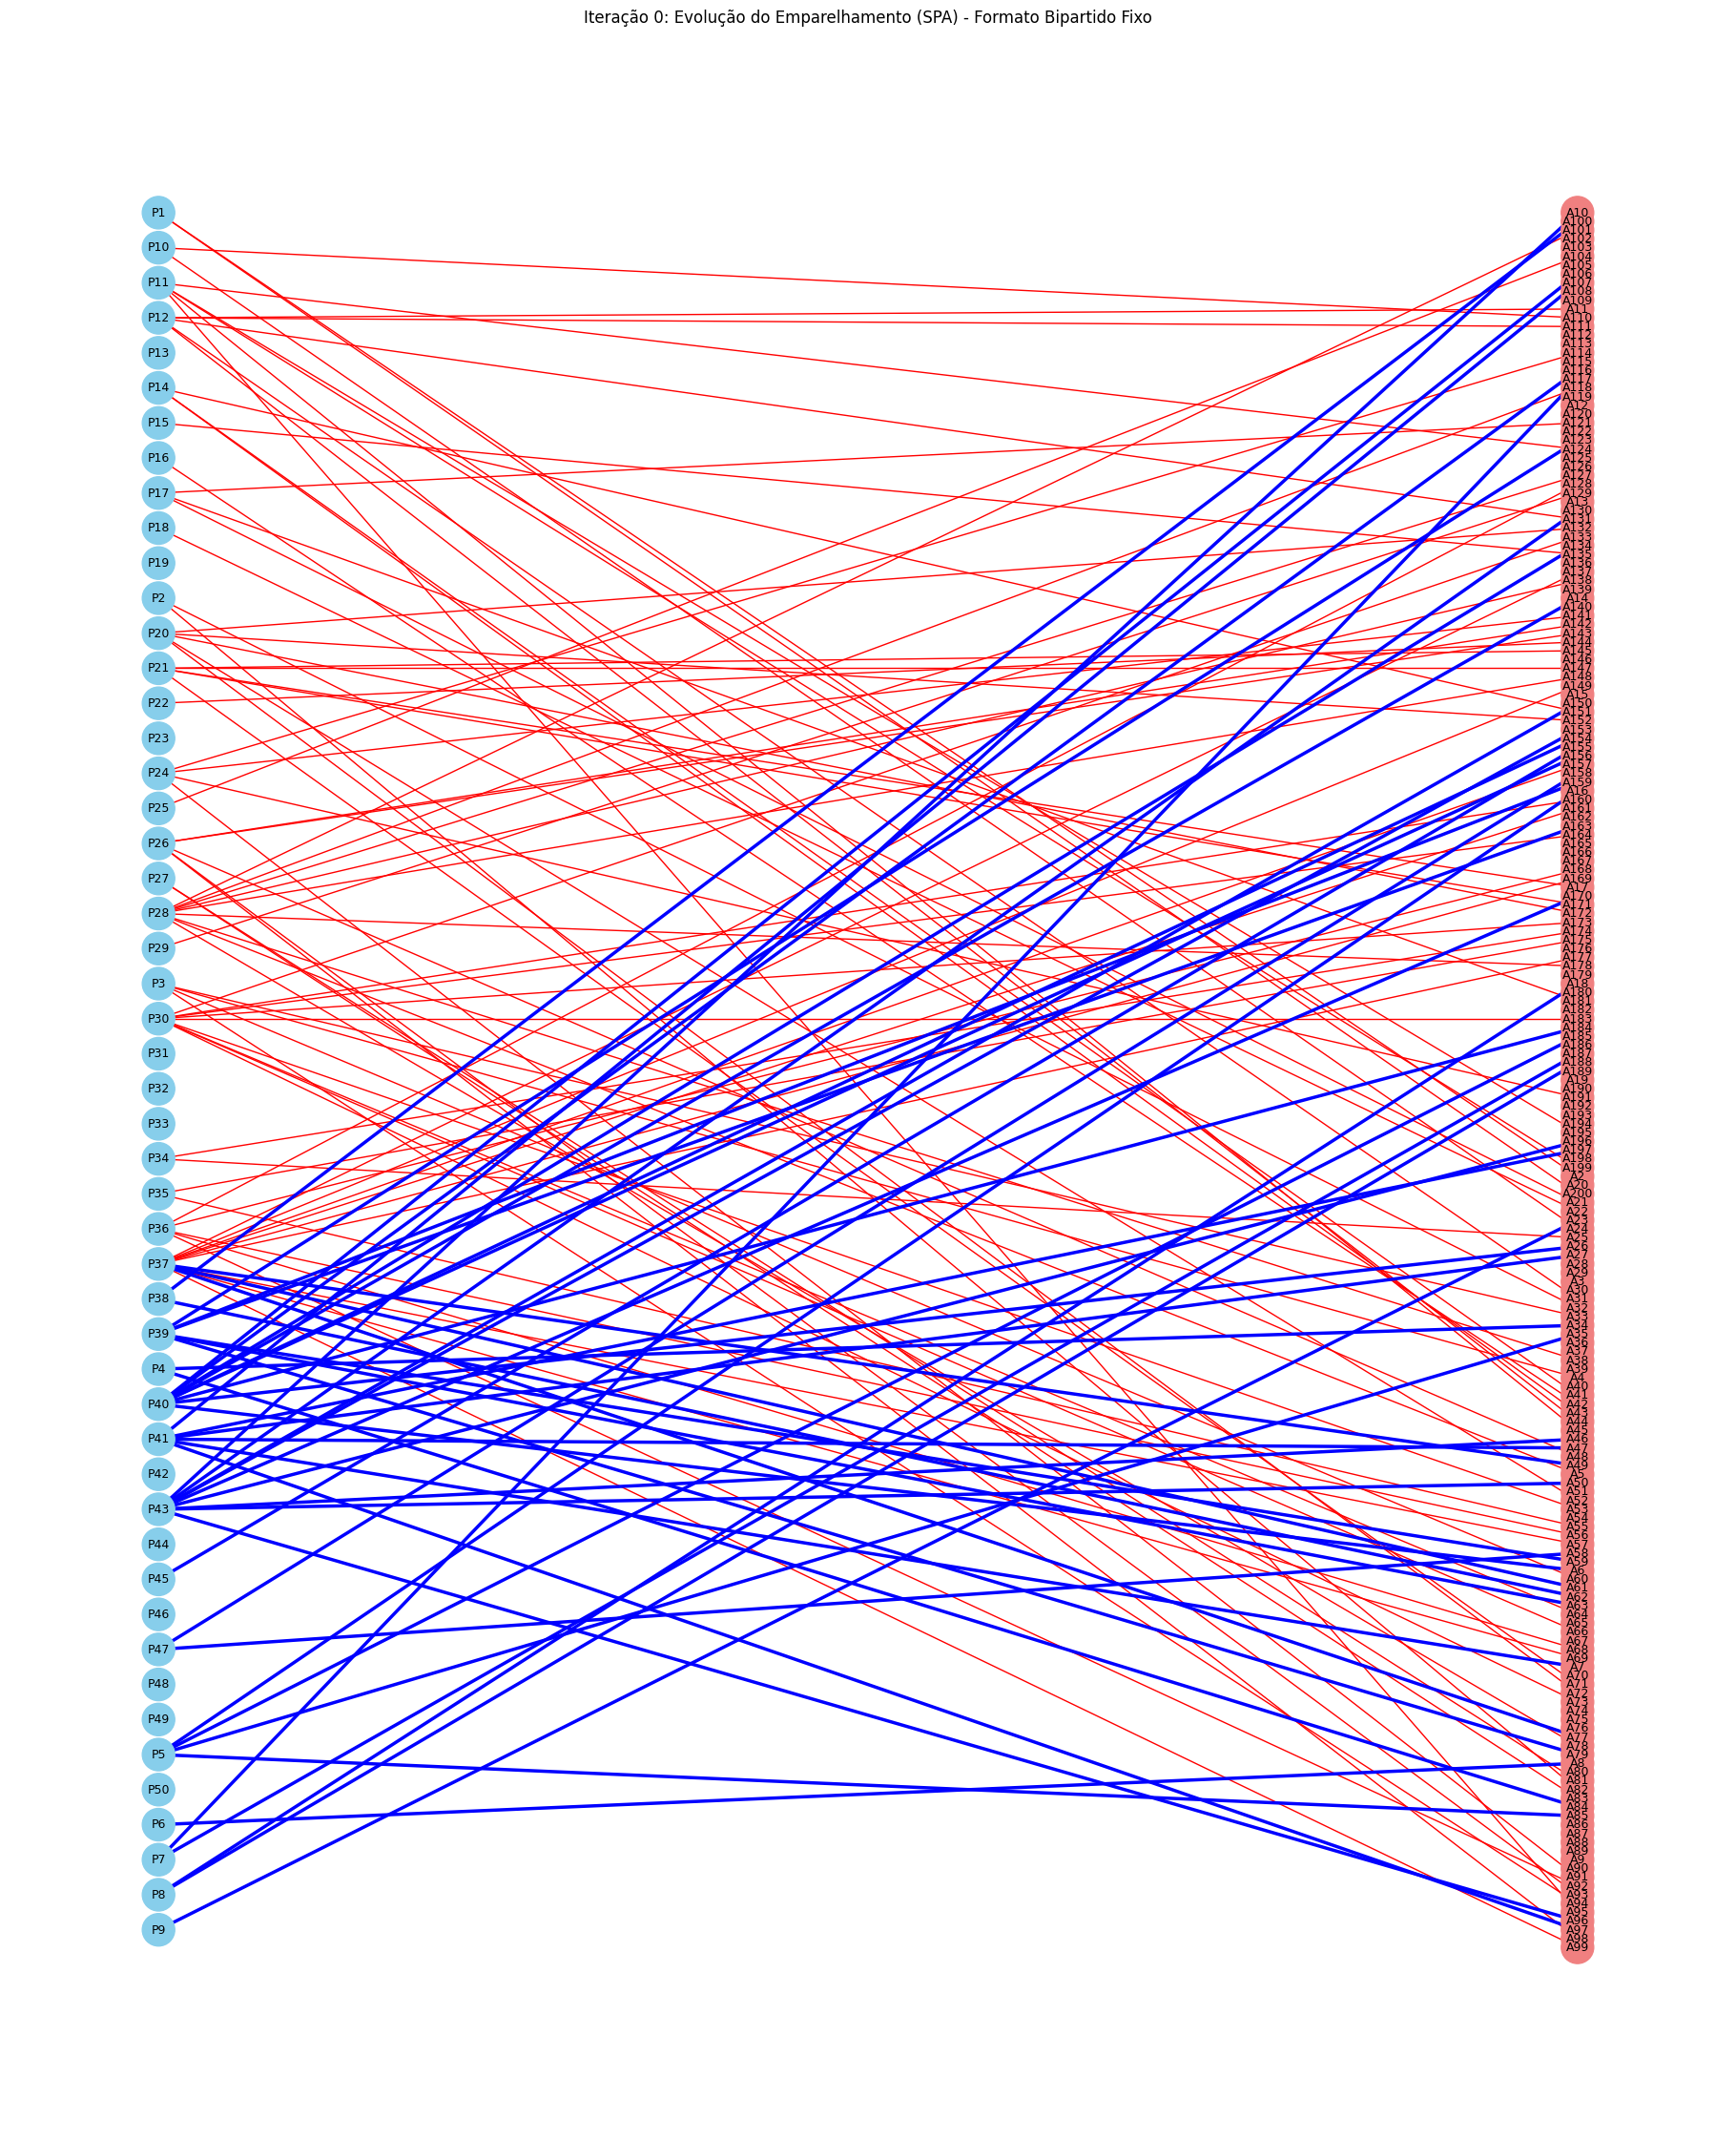

In [9]:
# Visualização da Evolução (Obrigatório mostrar a evolução)

if len(historico_iteracoes) > 0:
    visualizar_grafo(projetos, alunos, historico_iteracoes[0], 0)

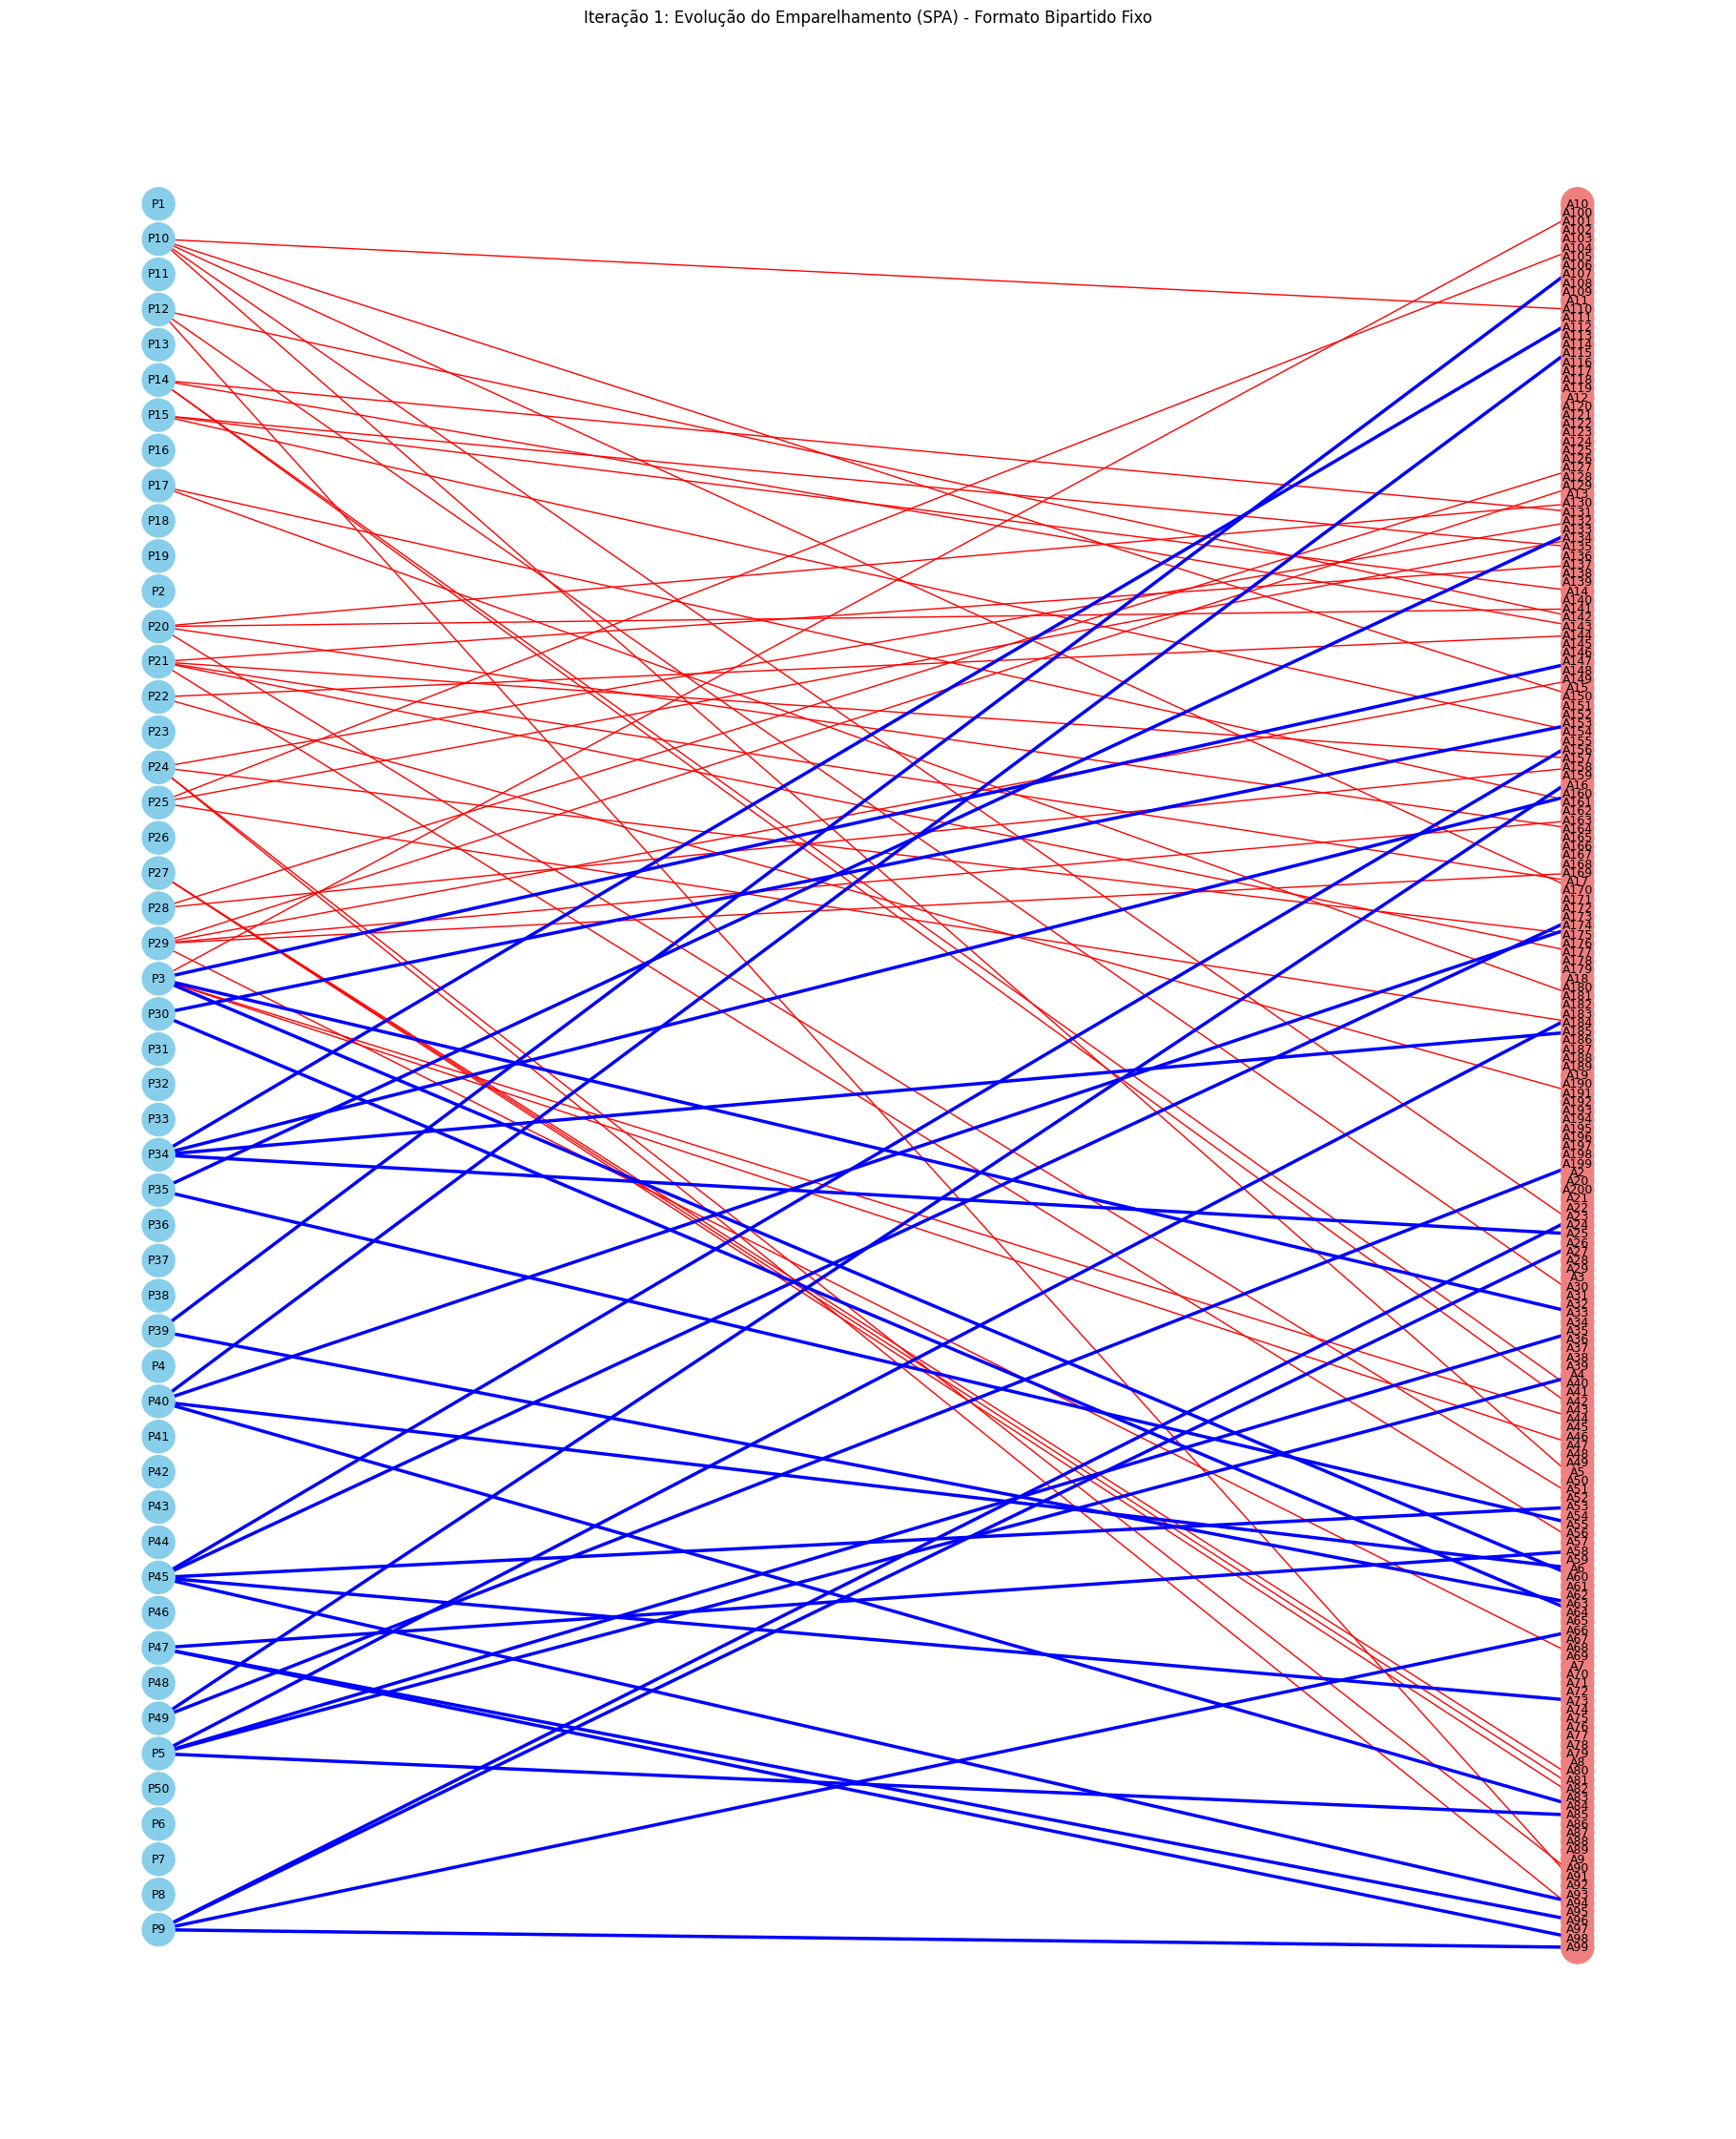

In [10]:
if len(historico_iteracoes) > 1:
    visualizar_grafo(projetos, alunos, historico_iteracoes[1], 1)

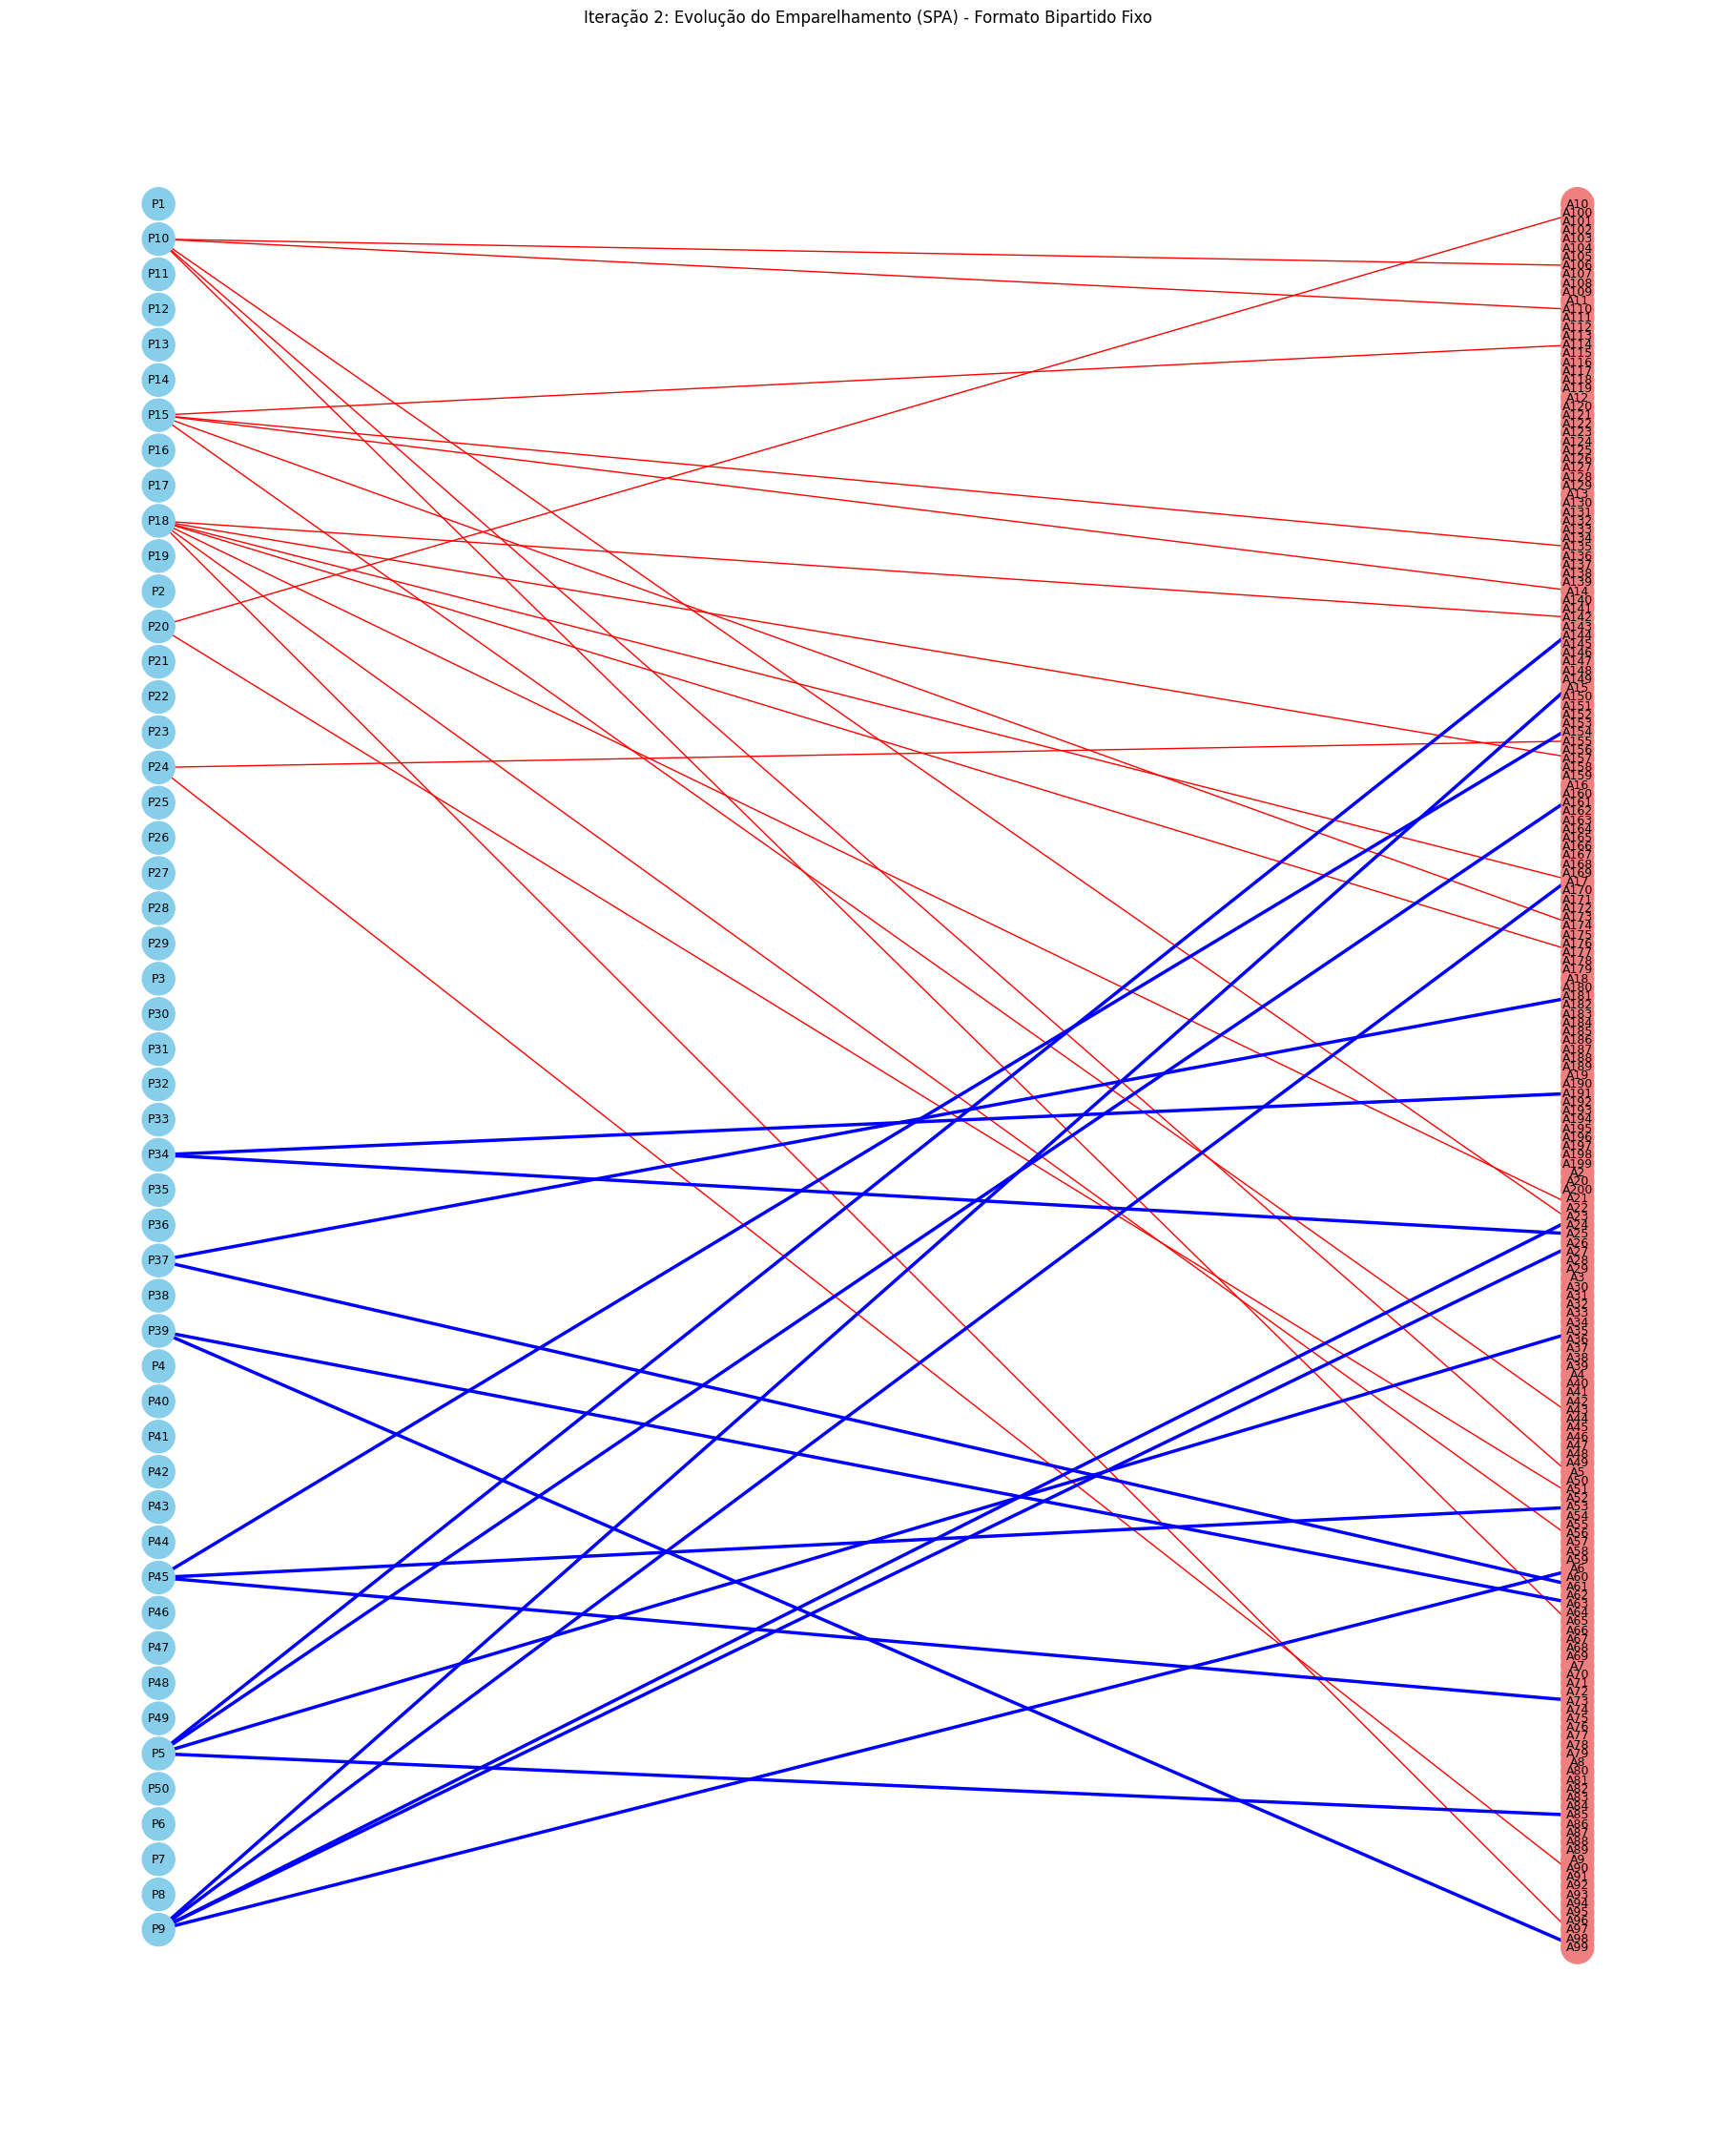

In [11]:
if len(historico_iteracoes) > 2:
    visualizar_grafo(projetos, alunos, historico_iteracoes[2], 2)

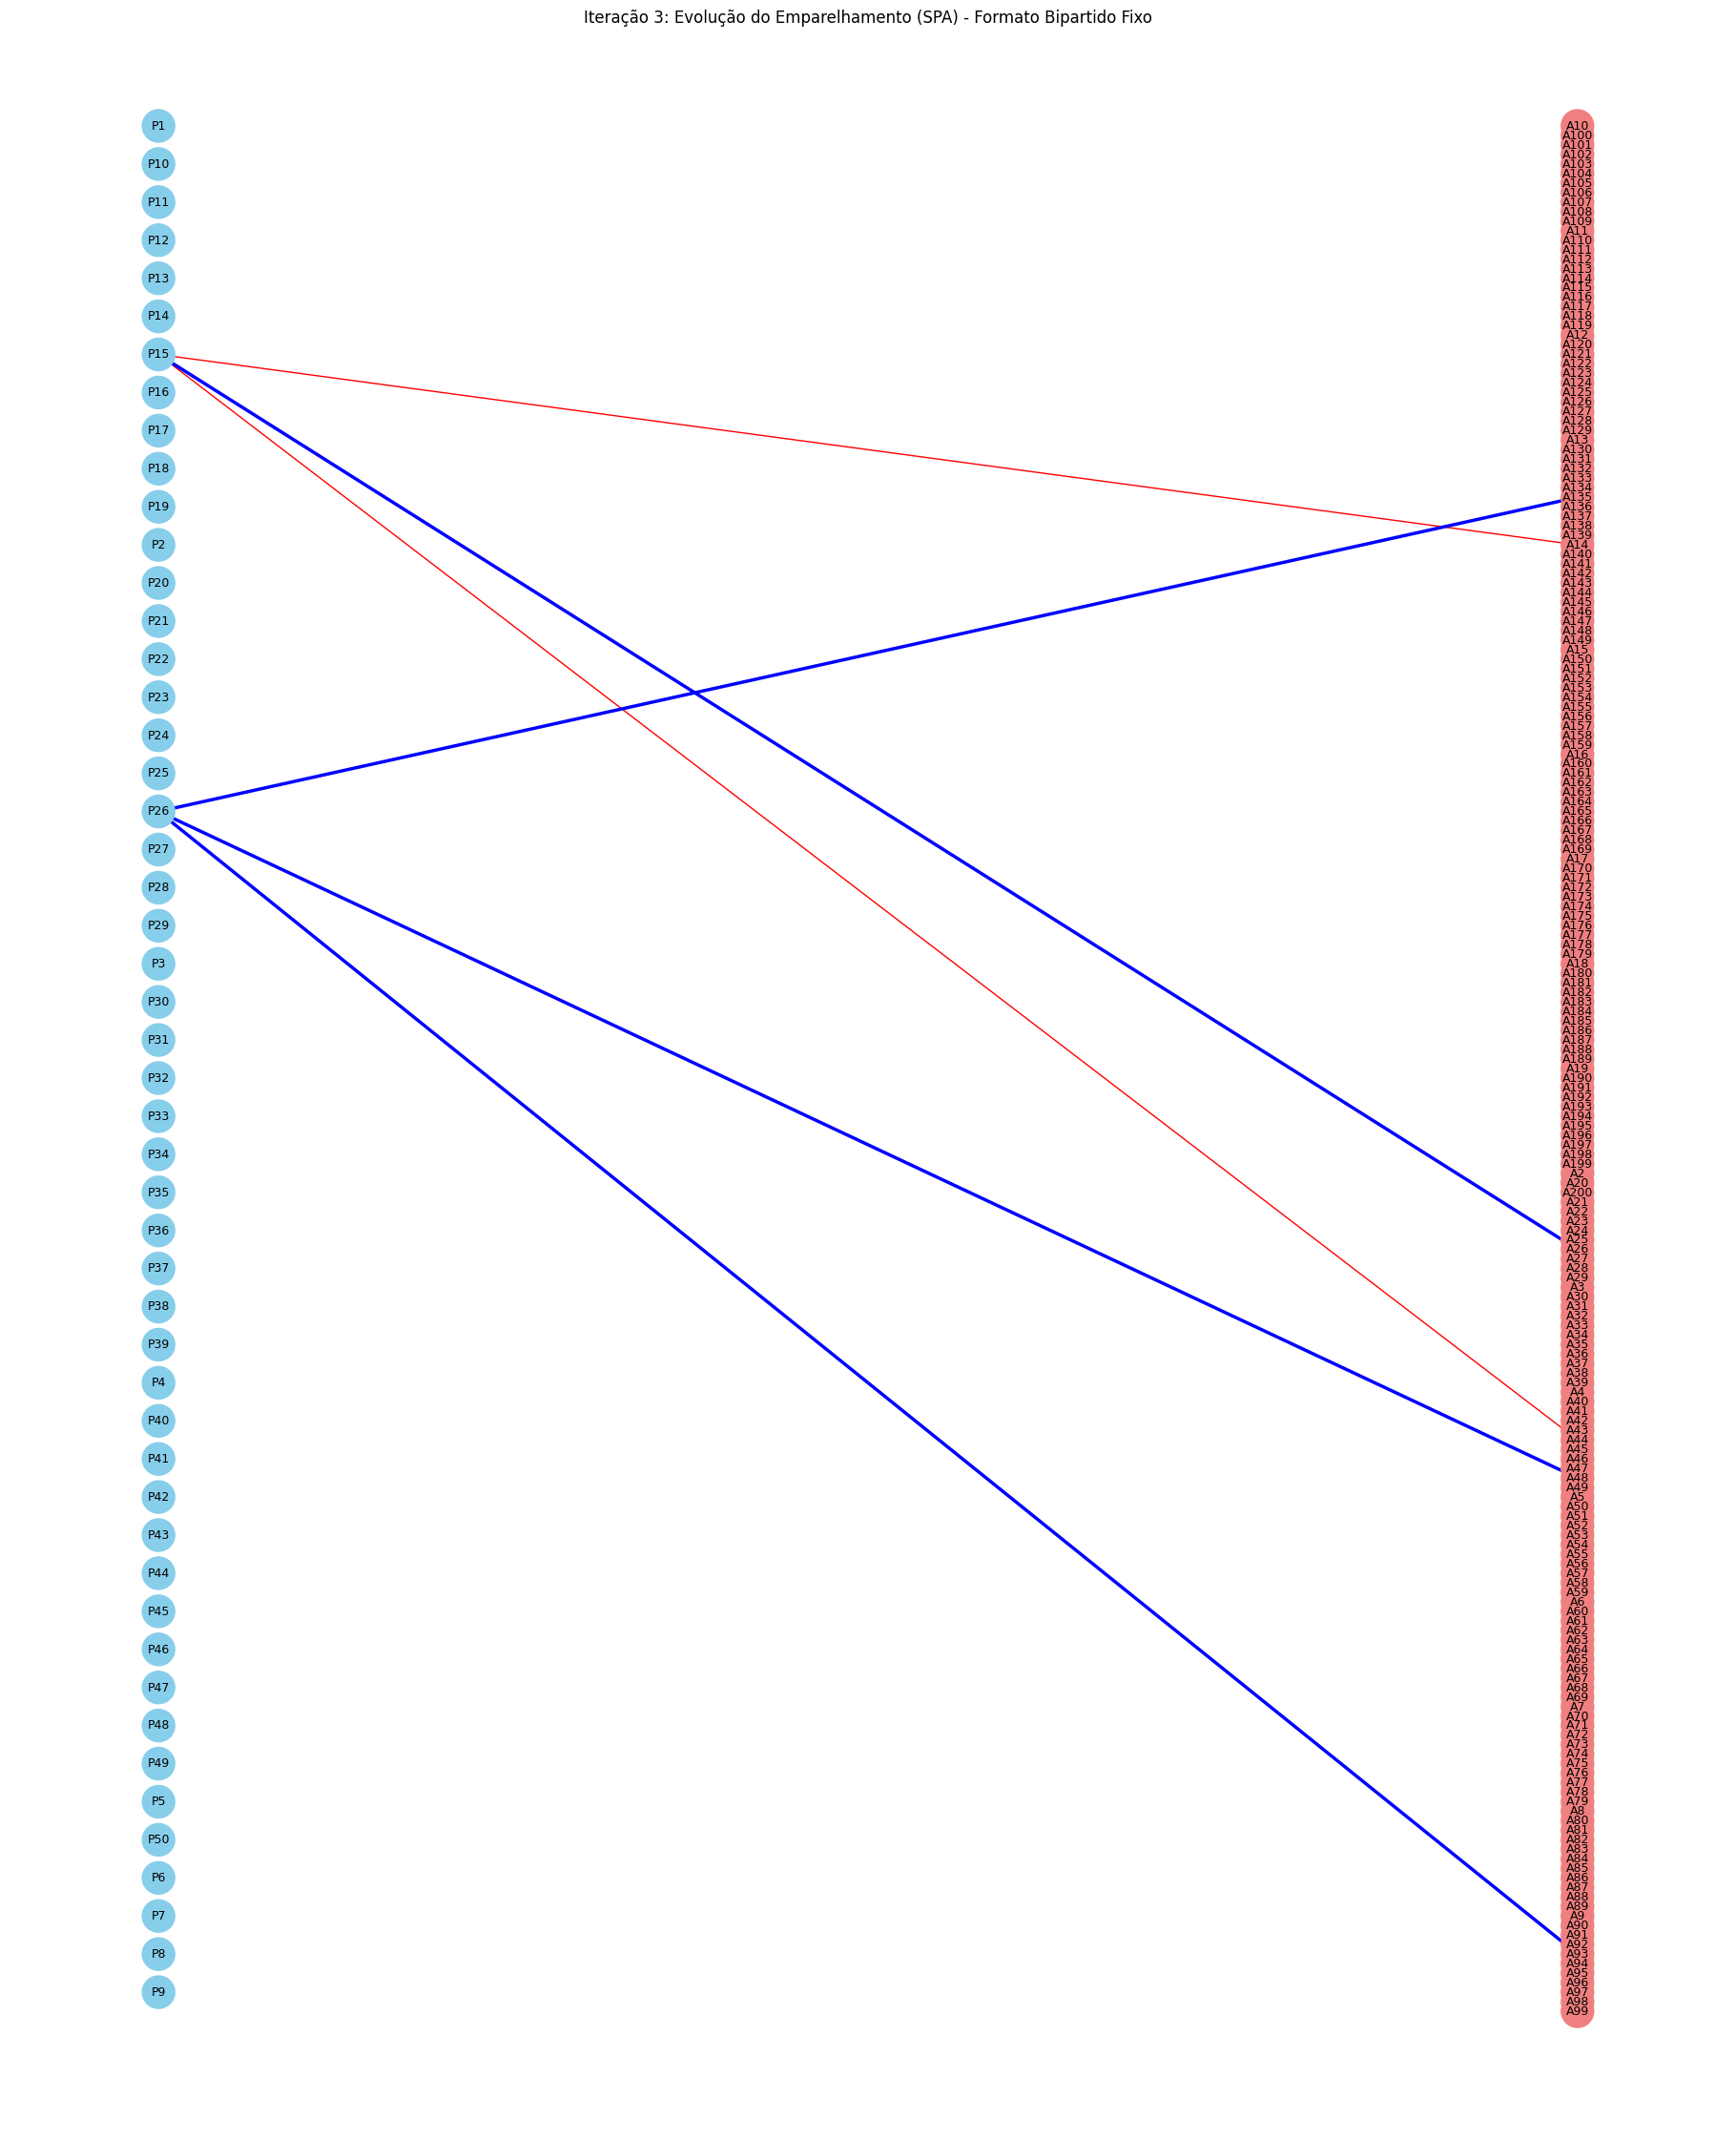

In [12]:
if len(historico_iteracoes) > 3:
    visualizar_grafo(projetos, alunos, historico_iteracoes[3], 3)

## 9. Saídas finais, tabelas de emparelhamento

In [13]:
gerar_matriz_emparelhamento(alunos, projetos)


--- MATRIZ FINAL DE EMPARELHAMENTO ESTÁVEL ---


Aluno  Nota (N) Projeto Emparelhado  Req. Min. Nota (R)  \
0     A2         5                  P1                   5   
1     A6         4                  P9                   4   
2     A8         5                  P6                   5   
3    A10         4                 P43                   4   
4    A14         4                 P15                   4   
5    A18         5                  P8                   5   
6    A23         4                  P9                   4   
7    A24         4                 P10                   4   
8    A25         4                 P34                   4   
9    A26         4                 P15                   4   
10   A31         5                 P12                   3   
11   A32         5                  P2                   5   
12   A33         5                  P3                   4   
13   A34         5                  P4                   5   
14   A35         5                  P5                   4   
15   A41         4                 P14                   4   
16   A42         4                 P16                   4   
17   A43         4                 P14                   4   
18   A45         4                 P11                   3   
19   A46         4                 P43                   4   
20   A48         4                 P26                   4   
21   A50         4                 P10                   4   
22   A53         4                 P45                   4   
23   A55         4                 P35                   4   
24   A56         4                 P36                   4   
25   A58         4                 P47                   4   
26   A60         5                  P3                   4   
27   A61         5                 P37                   3   
28   A62         5                 P38                   5   
29   A63         5                 P39                   3   
30   A64         5                 P30                   4   
31   A66         4                 P10                   4   
32   A68         4                 P36                   4   
33   A69         4                 P29                   4   
34   A73         4                 P45                   4   
35   A81         5                 P27                   5   
36   A82         5                 P27                   5   
37   A83         5                 P27                   5   
38   A84         5                 P40                   4   
39   A85         5                  P5                   4   
40   A91         4                 P24                   4   
41   A93         4                 P26                   4   
42  A100         5                 P20                   4   
43  A104         4                 P25                   4   
44  A107         5                 P41                   4   
45  A117         5                  P7                   5   
46  A127         5                 P28                   3   
47  A129         4                 P29                   4   
48  A137         5                 P21                   4   
49  A144         4                 P22                   4   
50  A157         5                 P18                   4   
51  A159         4                 P49                   4   
52  A161         4                 P17                   3   
53  A177         5                 P18                   4   
54  A187         5                  P7                   5   
55  A188         5                  P8                   5   
56  A197         5                 P41                   4   
57  A200         5                  P1                   5   

   Rank do Projeto (Lista do Aluno) Rank do Aluno (Lista do Projeto)  
0               1° (Escolha 1 de 3)                 1° (Rank 1 de 4)  
1               2° (Escolha 2 de 3)                 1° (Rank 1 de 8)  
2               1° (Escolha 1 de 3)                 1° (Rank 1 de 1)  
3               2° (Escolha 2 de 3)                 1° (Rank

In [14]:
calcular_indice_preferencia(alunos, projetos)


--- ÍNDICE DE PREFERÊNCIA POR PROJETO (Média do Rank do Aluno) ---
Total de Alunos Alocados: 58 de 199
Total de Projetos Alocados (pelo menos 1 aluno): 39 de 50
Total de Projetos que Atenderam ao Requisito Mínimo (1 aluno): 39


Índice Médio de Rank  Vagas Preenchidas        Status
Projeto                                                       
P13                       0.0                  0  Não Atendido
P32                       0.0                  0  Não Atendido
P23                       0.0                  0  Não Atendido
P19                       0.0                  0  Não Atendido
P31                       0.0                  0  Não Atendido
P44                       0.0                  0  Não Atendido
P48                       0.0                  0  Não Atendido
P33                       0.0                  0  Não Atendido
P42                       0.0                  0  Não Atendido
P46                       0.0                  0  Não Atendido
P50                       0.0                  0  Não Atendido
P22                       1.0                  1      Atendido
P11                       1.0                  1      Atendido
P6                        1.0                  1      Atendido
P12                       1.0                  1      Atendido
P16                       1.0                  1      Atendido
P35                       1.0                  1      Atendido
P38                       1.0                  1      Atendido
P37                       1.0                  1      Atendido
P49                       1.0                  1      Atendido
P41                       1.5                  2      Atendido
P43                       1.5                  2      Atendido
P26                       1.5                  2      Atendido
P36                       1.5                  2      Atendido
P7                        1.5                  2      Atendido
P9                        1.5                  2      Atendido
P3                        1.5                  2      Atendido
P40                       2.0                  1      Atendido
P28                       2.0                  1      Atendido
P21                       2.0                  1      Atendido
P2                        2.0                  1      Atendido
P4                        2.0                  1      Atendido
P47                       2.0                  1      Atendido
P39                       2.0                  1      Atendido
P45                       2.5                  2      Atendido
P14                       2.5                  2      Atendido
P1                        2.5                  2      Atendido
P18                       2.5                  2      Atendido
P15                       2.5                  2      Atendido
P5                        2.5                  2      Atendido
P25                       3.0                  1      Atendido
P34                       3.0                  1      Atendido
P20                       3.0                  1      Atendido
P17                       3.0                  1      Atendido
P8                        3.5                  2      Atendido
P29                       3.5                  2      Atendido
P24                       4.0                  1      Atendido
P30                       4.0                  1      Atendido
P27                       5.0                  3      Atendido
P10                       5.0                  3      Atendido